# Regression and geography

> **The contents is not complete**
>
> This section is in works and is not yet complete.

When trying to determine the effect of some (independent) variables on
the outcome of phenomena (dependent variable), you often use regression
to model such an outcome and understand the influence each of the
variables has in the model. With spatial regression, it is the same. You
just need to use the spatial dimension in a mindful way.

This chapter provides an introduction to ways of incorporating space
into regression models, from spatial variables in standard linear
regression to geographically weighted regression.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import mgwr
import seaborn as sns
import matplotlib.pyplot as plt
from libpysal import graph
import statsmodels.formula.api as sm
import esda
from splot.esda import lisa_cluster

## Data

You will work with the same data you already used in the chapter on
[spatial autocorrelation](../chapter_05/hands_on.qmd) - the results of
the second round of the presidential elections in Czechia in 2023,
between Petr Pavel and Andrej Babiš, on a level of municipalities. You
can read the election data directly from the chapter 5 location.

In [2]:
elections = gpd.read_file(
    "https://martinfleischmann.net/sds/chapter_05/data/cz_elections_2023.gpkg"
)
elections = elections.set_index("name")
elections.head()

> **Alternative**
>
> Instead of reading the file directly off the web, it is possible to
> download it manually, store it on your computer, and read it locally.
> To do that, you can follow these steps:
>
> 1.  Download the file by right-clicking on [this
>     link](https://martinfleischmann.net/sds/chapter_05/data/cz_elections_2023.gpkg)
>     and saving the file
> 2.  Place the file in the same folder as the notebook where you intend
>     to read it
> 3.  Replace the code in the cell above with:
>
> ``` python
> elections = gpd.read_file(
>     "cz_elections_2023.gpkg",
> )
> ```

The election results give you the dependent variable - you will look at
the percentage of votes Petr Pavel, the winner, received. From the [map
of the results](../chapter_05/hands_on.qmd#code-cell-2) and the analysis
you did when exploring spatial autocorrelation you already know that
there are some significant spatial patterns. Let’s look whether these
patterns correspond to the composition of education levels within each
municipality.

You can use the data from the [Czech Statistical
Office](https://www.czso.cz/csu/czso/vysledky-scitani-2021-otevrena-data)
reflecting the situation during the Census 2021. The original table has
been [preprocessed](../data/cz_education_2021/preprocessing.ipynb) and
is available as a CSV.

In [3]:
education = pd.read_csv(
    "https://martinfleischmann.net/sds/chapter_10/data/education.csv"
)
education.head()

> **Alternative**
>
> Instead of reading the file directly off the web, it is possible to
> download it manually, store it on your computer, and read it locally.
> To do that, you can follow these steps:
>
> 1.  Download the file by right-clicking on [this
>     link](%22https://martinfleischmann.net/sds/chapter_10/data/education.csv%22)
>     and saving the file
> 2.  Place the file in the same folder as the notebook where you intend
>     to read it
> 3.  Replace the code in the cell above with:
>
> ``` python
> education = pd.read_csv(
>     "education.csv",
> )
> ```

The first thing you need to do is to merge the two tables, to have both
dependent and independent variables together. The municipality code in
the `elections` table is in the `"nationalCode"` column, while in the
education table in the `"uzemi_kod"` column.

In [4]:
elections_data = elections.merge(education, left_on="nationalCode", right_on="uzemi_kod")
elections_data.head()

5 rows × 21 columns

That is all sorted and ready to be used in a regression.

## Non-spatial linear regression

Before jumping into spatial regression, let’s start with the standard
linear regression. A useful start is to explore the data using an
ordinary least squares (OLS) linear regression model.

### OLS model

While this course is not formula-heavy, in this case, it is useful to
use the formula to explain the logic of the algorithm. The OLS tries to
model the dependent variable $y$ as the linear combination of
independent variables $x_1, x_2, ... x_n$:

$$y_{i}=\alpha+\beta _{1}\ x_{i1}+\beta _{2}\ x_{i2}+\cdots +\beta _{p}\ x_{ip}+\varepsilon _{i}$$

where $\epsilon_{i}$ represents unobserved random variables and $\alpha$
represents an intercept - a constant. You know the $y_i$, all of the
$x_i$ and try to estimate the coefficients. In Python, you can run
linear regression using implementations from more than one package
(e.g., `statsmodels`, `scikit-learn`, `spreg`). This course covers
`statsmodels` approach as it has a nice API to work with.

First, you need a list of names of independent variables. That is equal
to column names without a few of the columns that represent other data.

In [5]:
independent_names = education.columns.drop(["uzemi_kod", "okres", "without_education"])
independent_names

Index(['undetermined', 'incomplete_primary_education',
       'lower_secondary_and_secondary_education', 'further_education',
       'post_maturita_studies', 'bachelors_degree', 'doctoral_degree',
       'masters_degree', 'higher_vocational_education',
       'higher_vocational_education_in_a_conservatory', 'primary_education',
       'complete_secondary_vocational_education',
       'complete_secondary_general_education'],
      dtype='object')

`statsmodels` (above imported as `sm`) offers an intuitive formula API
to define the linear regression.

In [6]:
formula = f"PetrPavel ~ {' + '.join(independent_names)}"
formula


'PetrPavel ~ undetermined + incomplete_primary_education + lower_secondary_and_secondary_education + further_education + post_maturita_studies + bachelors_degree + doctoral_degree + masters_degree + higher_vocational_education + higher_vocational_education_in_a_conservatory + primary_education + complete_secondary_vocational_education + complete_secondary_general_education'

With the formula ready, you can fit the model and estimate all betas and
$\varepsilon$.

In [7]:
ols = sm.ols(formula, data=elections_data).fit()

The `ols` object offers a handy `summary()` function providing most of
the results from the fitting in one place.

In [8]:
ols.summary()

Notes: [1] Standard Errors assume that the covariance matrix of the errors is correctly specified. [2] The condition number is large, 3.88e+03. This might indicate that there are strong multicollinearity or other numerical problems.

It is clear that education composition has a significant effect on the
outcome of the elections but can explain only about 42% of its variance
(adjusted $R^2$ is 0.422). A higher amount of residents with only
primary education tends to lower Pavel’s gain while a higher amount of
university degrees tends to increase the number of votes he received.
That is nothing unexpected. However, let’s make use of geography and
unpack these results a bit.

### Spatial exploration of the model (hidden structures)

Start with the visualisation of the prediction the OLS model produces
using the coefficients shown above.

In [9]:
predicted = ols.predict(elections_data)
predicted.head()


0    41.731952
1    58.447707
2    73.554706
3    53.281638
4    48.993730
dtype: float64

Make a plot comparing the prediction with the actual results.

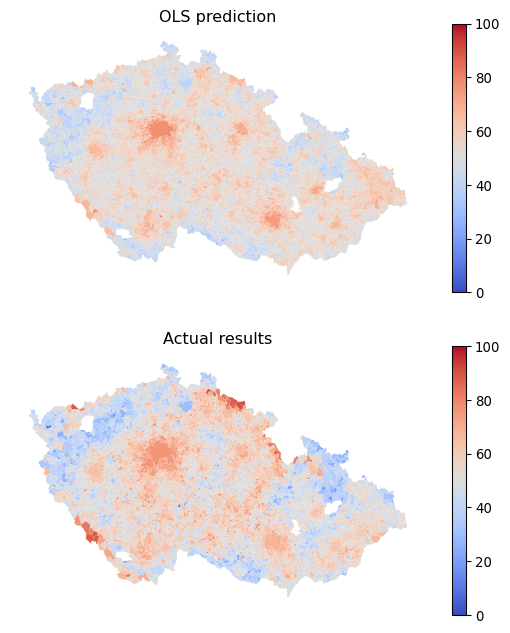

In [10]:
f, axs = plt.subplots(2, 1, figsize=(7, 8))
elections_data.plot(
    predicted, legend=True, cmap="coolwarm", vmin=0, vmax=100, ax=axs[0]
)
elections_data.plot(
    "PetrPavel", legend=True, cmap="coolwarm", vmin=0, vmax=100, ax=axs[1]
)
axs[0].set_title("OLS prediction")
axs[1].set_title("Actual results")

axs[0].set_axis_off()
axs[1].set_axis_off()


The general patterns are captured but there are some areas of the
country which seem to be quite off. The actual error between prediction
and the dependent variable is captured as *residuals*, which are
directly available in `ols` as `ols.resid` attribute. Let’s plot to get
a better comparison.

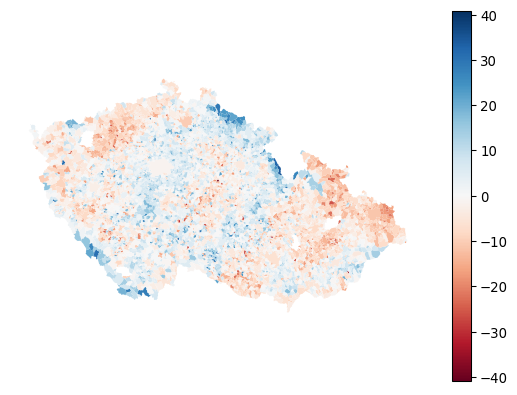

In [11]:
elections_data["residual"] = ols.resid
max_residual = ols.resid.abs().max()
ax = elections_data.plot(
    "residual", legend=True, cmap="RdBu", vmin=-max_residual, vmax=max_residual
)
ax.set_axis_off()


All of the municipalities in blue (residual above 0) have reported
higher gains for Petr Pavel than the model assumes based on education
structure, while all in red reported lower gains than what is expected.
However, as data scientists, we have better tools to analyse the spatial
structure of residuals than eyeballing it. Let’s recall the chapter on
spatial autocorrelation again and figure out the spatial clusters of
residuals.

First, create a contiguity graph and row-normalise it.

In [12]:
contiguity_r = graph.Graph.build_contiguity(elections_data).transform("r")

Then you can generate a Moran plot of residuals. For that, you will need
the lag of residuals.

In [13]:
elections_data["residual_lag"] = contiguity_r.lag(elections_data["residual"])

And then you can use the code from the earlier chapter to generate a
Moran scatterplot using `seaborn`.

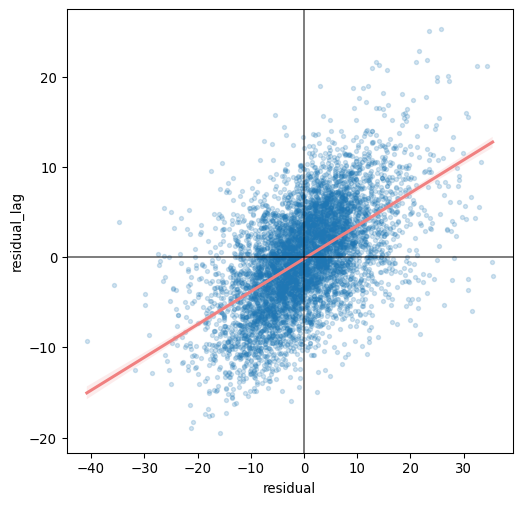

In [14]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="residual",
    y="residual_lag",
    data=elections_data,
    marker=".",
    scatter_kws={"alpha": 0.2},
    line_kws=dict(color="lightcoral")
)
plt.axvline(0, c="black", alpha=0.5)
plt.axhline(0, c="black", alpha=0.5);

That looks like a pretty strong relationship. Use the local version of
Moran’s statistic to find out the clusters.

In [15]:
lisa = esda.Moran_Local(elections_data['residual'], contiguity_r.to_W())


Let’s use our handy `lisa_cluster` function from `splot` to visualise
the results.

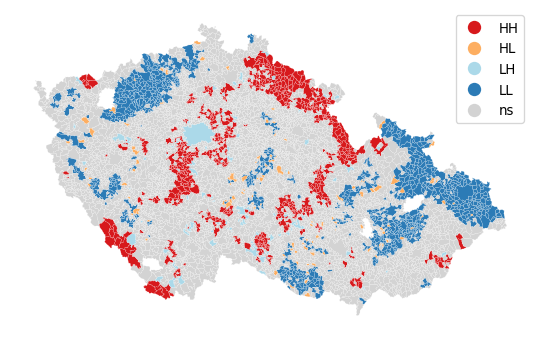

In [16]:
_ = lisa_cluster(lisa, elections_data)

The outcome of LISA shows large clusters of both overpredicted
(high-high) and underpredicted (low-low) areas. The underpredicted are
mostly in central Bohemia around Prague and in the mountains near the
borders, where the ski resorts are. Putting aside the central areas for
a bit, the explanation of underprediction in mountains is relatively
straightforward. The education data are linked to the residents of each
municipality. The people who voted in a municipality do not necessarily
need to match with residents. It is known that more affluent population
groups, who are more likely to go to a ski resort, voted overwhelmingly
for Pavel. And since the elections were in winter, a lot of them likely
voted in ski resorts, affecting the outcome of the model.

The overpredicted areas, on the other hand, are known for higher levels
of deprivation, which may have played a role in the results. What is
clear, is that geography plays a huge role in the modelling of the
elections.

## Spatial heterogeneity

Not all areas behave equally, it seems that some systematically vote for
Pavel more than for Babiš while others vote for him less. You need to
account for this when building a regression model. One way is by
capturing *spatial heterogeneity*. It implicitly assumes that the
outcome of the model spatially varies. You can expect $\alpha$ to vary
across space, or individual values of $\beta$. Spatial fixed effects
capture the former.

### Spatial fixed effects

You need to find a way to let $\alpha$ change across space. One option
is through the proxy variable capturing higher-level geography. You have
information about *okres* (the closest translation to English would
probably be district or county) each municipality belongs to. Let’s
start by checking if that could be useful by visualising residuals
within each. While you can use the box plot directly, it may be better
to sort the values by median residuals, so let’s complicate the code a
bit.

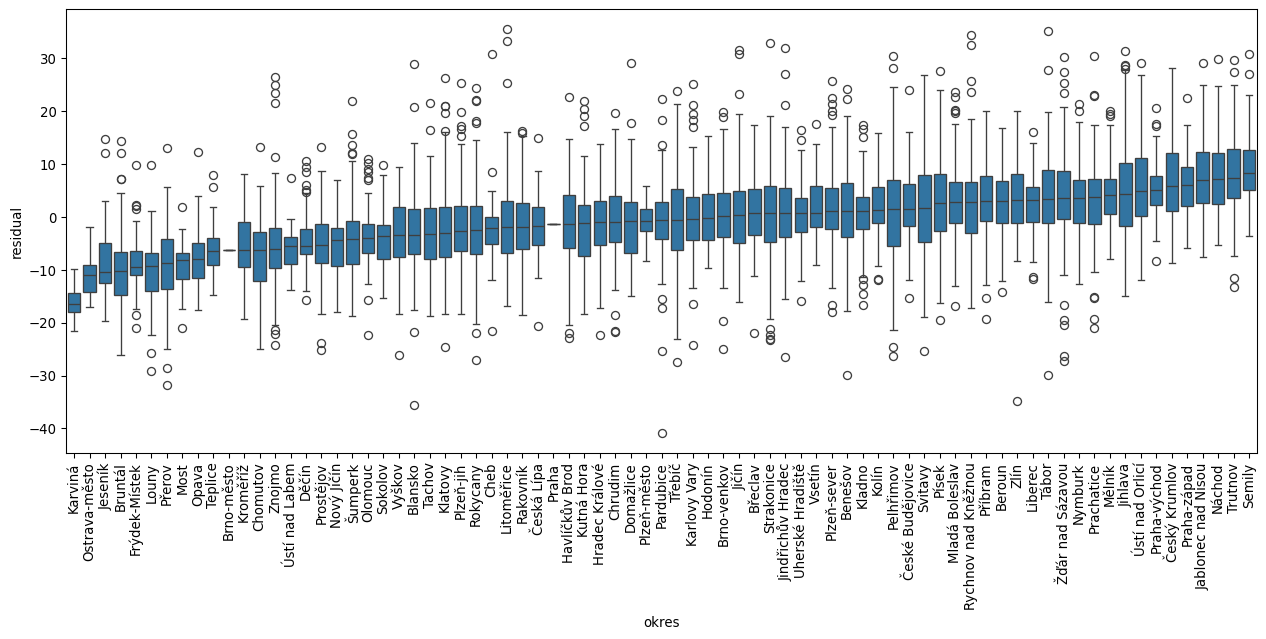

In [17]:
medians = (
    elections_data.groupby("okres")
    .residual.median()
    .to_frame("okres_residual")
)
f, ax = plt.subplots(figsize=(16, 6))
sns.boxplot(
    data=elections_data.merge(
        medians, how="left", left_on="okres", right_index=True
    ).sort_values("okres_residual"),
    x="okres",
    y="residual",
)
_ = plt.xticks(rotation=90)


In [18]:
formula_fe = f"PetrPavel ~ {' + '.join(independent_names)} + okres - 1"
ols_fe = sm.ols(formula_fe, data=elections_data).fit()

In [19]:
ols_fe.summary()

Notes: [1] Standard Errors assume that the covariance matrix of the errors is correctly specified. [2] The condition number is large, 3.43e+04. This might indicate that there are strong multicollinearity or other numerical problems.

In [20]:
fixed_effects = ols_fe.params.filter(like="okres")
fixed_effects.head()

okres[Benešov]        53.569563
okres[Beroun]         55.369844
okres[Blansko]        49.994365
okres[Brno-město]     47.337083
okres[Brno-venkov]    52.959431
dtype: float64

In [21]:
fixed_effects.index = fixed_effects.index.str.strip(
    "okres["
).str.strip("]")
fixed_effects.head()

Benešov        53.569563
Beroun         55.369844
Blansko        49.994365
Brno-město     47.337083
Brno-venkov    52.959431
dtype: float64

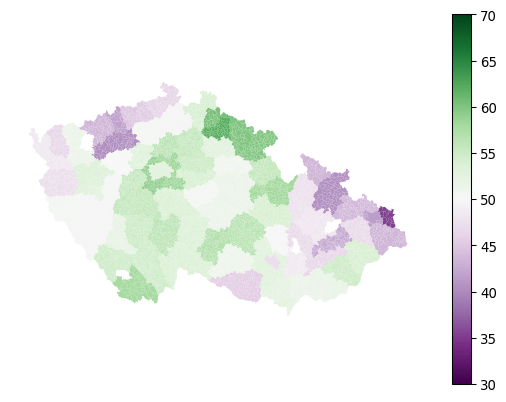

In [22]:
elections_data.merge(fixed_effects.to_frame("fixed_effect"), left_on="okres", right_index=True, how="left").plot("fixed_effect", legend=True, vmin=30, vmax=70, cmap="PRGn").set_axis_off()

> **Spatial regimes and spatial dependence**
>
> Link to the book
>
> ### Spatial regimes
>
> *differernces of constant and coefficients - spreg*
>
> ## Spatial dependence (possibly only via literature?)
>
> *based on spatial configuration via W* - *lagged explanatory* -
> *lagged error* - *lagged dependent as another explanatory (no OLS)*

## Geographically weighted regression

-   kernels
    -   shape
    -   size
    -   fixed / adaptive

https://smds-book.github.io/smds/08-weighted-regression-modelling.html

### Fixed bandwidth

In [23]:
coords = elections_data.centroid.get_coordinates().values
y = elections_data[f"PetrPavel"].values.reshape(-1, 1)
X = elections_data[independent_names].values

In [24]:
fixed_bandwidth = mgwr.gwr.GWR(coords, y, X, bw=25_000, fixed=True, name_x=independent_names)
results_fb = fixed_bandwidth.fit()

/home/runner/micromamba/envs/sds/lib/python3.11/site-packages/spglm/iwls.py:36: LinAlgWarning: Ill-conditioned matrix (rcond=4.36156e-20): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)

In [25]:
results_fb.summary()

Model type                                                         Gaussian
Number of observations:                                                6254
Number of covariates:                                                    14

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         472435.355
Log-likelihood:                                                  -22397.315
AIC:                                                              44822.630
AICc:                                                             44824.707
BIC:                                                             417891.662
R2:                                                                   0.423
Adj. R2:                                                              0.422

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

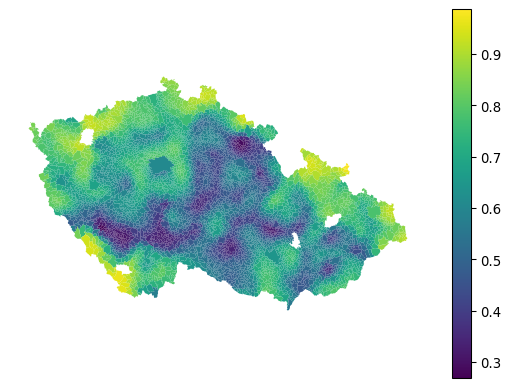

In [26]:
elections_data.plot(results_fb.localR2.flatten(), legend=True).set_axis_off()

### Adaptive bandwidth

In [27]:
sel_bw = mgwr.sel_bw.Sel_BW(coords, y, X)
bw = sel_bw.search()
bw

236.0

In [28]:
adaptive = mgwr.gwr.GWR(coords, y, X, bw=bw, fixed=False, name_x=independent_names)
results_ab = adaptive.fit()

In [29]:
results_ab.summary()

Model type                                                         Gaussian
Number of observations:                                                6254
Number of covariates:                                                    14

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         472435.355
Log-likelihood:                                                  -22397.315
AIC:                                                              44822.630
AICc:                                                             44824.707
BIC:                                                             417891.662
R2:                                                                   0.423
Adj. R2:                                                              0.422

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

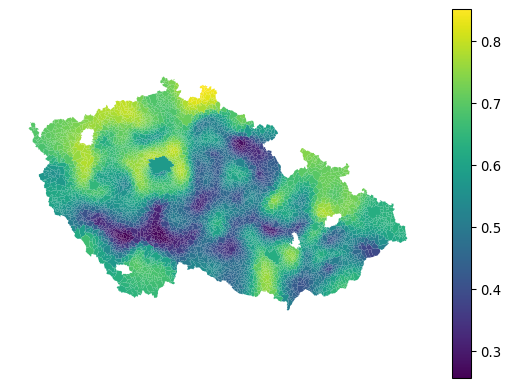

In [30]:
elections_data.plot(results_ab.localR2.flatten(), legend=True).set_axis_off()

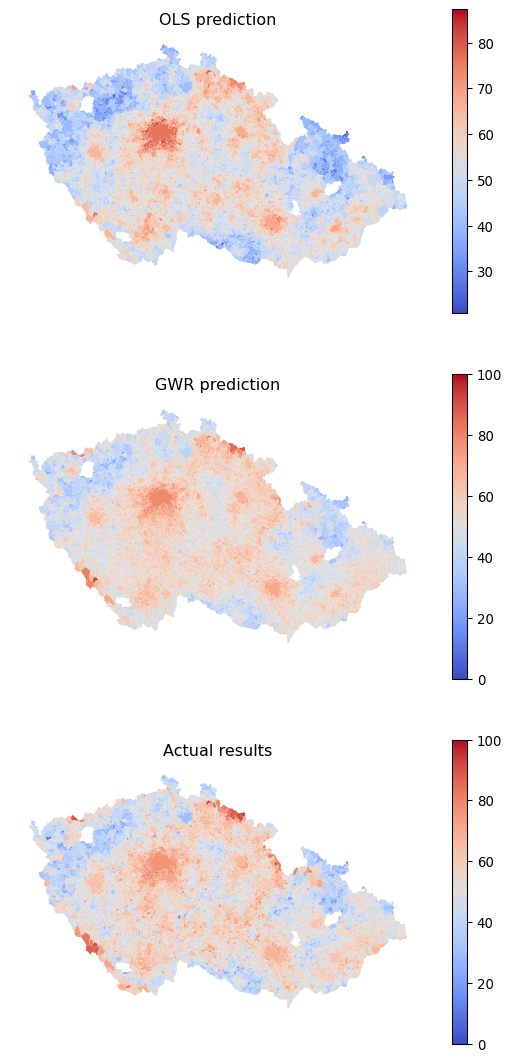

In [31]:
f, axs = plt.subplots(3, 1, figsize=(7, 14))
elections_data.plot(ols_fe.predict(elections_data), legend=True, cmap="coolwarm",
 ax=axs[0])
elections_data.plot(results_ab.predy.flatten(), legend=True, cmap="coolwarm",
    vmin=0,
    vmax=100, ax=axs[1]).set_axis_off()

elections_data.plot("PetrPavel", legend=True, cmap="coolwarm",
   vmin=0,
    vmax=100, ax=axs[2])
axs[0].set_title("OLS prediction")
axs[1].set_title("GWR prediction")
axs[2].set_title("Actual results")

axs[0].set_axis_off()
axs[1].set_axis_off()
axs[2].set_axis_off()

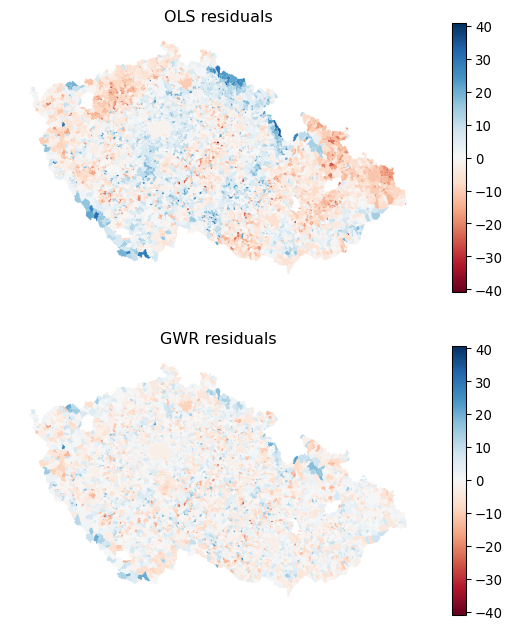

In [32]:
f, axs = plt.subplots(2, 1, figsize=(7, 8))
elections_data.plot("residual", legend=True, cmap="RdBu", vmin=-max_residual, vmax=max_residual, ax=axs[0])
elections_data.plot(results_ab.resid_response.flatten(), legend=True, cmap="RdBu", vmin=-max_residual, vmax=max_residual, ax=axs[1])
axs[0].set_title("OLS residuals")
axs[1].set_title("GWR residuals")

axs[0].set_axis_off()
axs[1].set_axis_off()

In [33]:
results_ab.adj_alpha

array([1.51580412e-03, 7.57902061e-04, 1.51580412e-05])

In [34]:
sig95 = results_ab.adj_alpha[1]
critical_t = results_ab.critical_tval(alpha=sig95)
critical_t

3.3693909198636196

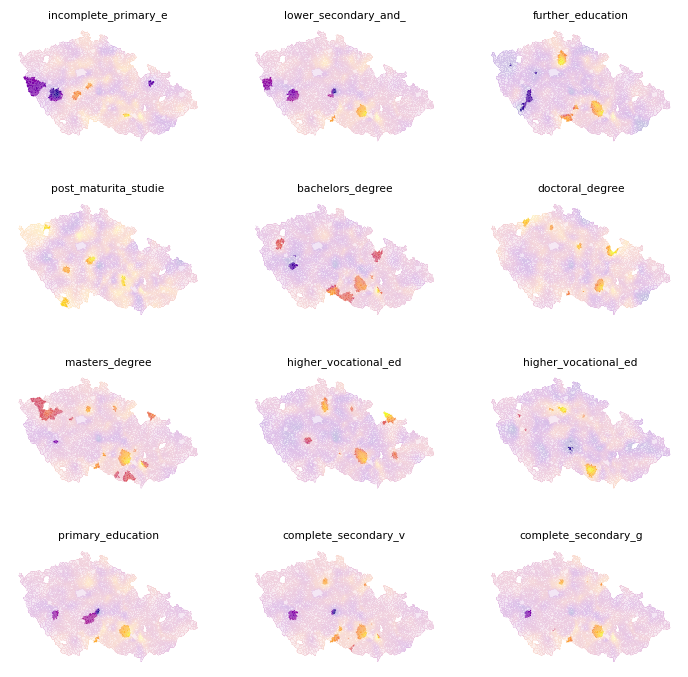

In [35]:
significant = np.abs(results_ab.tvalues) > critical_t

fig, axs = plt.subplots(4, 3, figsize=(9, 9))
axs = axs.flatten()
for i, name in enumerate(independent_names[1:]):
    significant_mask = significant[:, i + 2]
    elections_data.plot(results_ab.params[:, i + 2], cmap="plasma", ax=axs[i])
    elections_data[~significant_mask].plot(color="white", ax=axs[i], alpha=.9)
    axs[i].set_title(name[:20], fontdict={'fontsize': 8})
    axs[i].set_axis_off()